In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# import higherOrderKME
# from higherOrderKME import sigkernel
import Path_Char
from Path_Char.path_characteristic_function import char_func_path
from Path_Char.model import LSTMRegressor, LSTMRegressor_with_M, LSTMRegressor_with_M_2
from Path_Char.utils import AddTime
from torch.utils.data import DataLoader, Dataset
from Path_Char.high_level_pcf import expected_dev
import ml_collections
from torch.distributions import Bernoulli
import seaborn as sns
import os
from fbm import FBM
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sns.set()
torch.manual_seed(0)
device = 'cuda'

In [2]:
def FBM_data(num_samples, dim, length, h):
    fbm_paths = []
    for i in range(num_samples*dim):
        f = FBM(n=length, hurst=h, method='daviesharte')
        fbm_paths.append(f.fbm())
    data = torch.FloatTensor(np.array(fbm_paths)).reshape(
        num_samples, dim, length+1).permute(0, 2, 1)
    return data

In [3]:
# Construct fbm path with different Hurst parameter

samples = 20000
steps = 50

bm = FBM_data(samples, dim=3, length=steps, h=0.5)
fbm_h = FBM_data(samples, dim=3, length=steps, h=0.475)

bm_test = FBM_data(4000, dim=3, length=steps, h=0.5)
fbm_h_test = FBM_data(4000, dim=3, length=steps, h=0.475)

fbm_h = fbm_h.to(device)
bm = bm.to(device)
fbm_h_test = fbm_h_test.to(device)
bm_test = bm_test.to(device)

In [4]:
config = {'G_input_dim': 4,
          'G_hidden_dim': 128,
          'G_num_layers': 2,
          'G_output_dim': 5}
config = ml_collections.ConfigDict(config)

In [5]:
# Construct rank 1 pcf discriminator
input_dim = fbm_h.shape[-1]
num_samples_1 = 1
lie_degree_1 = 5
pcf_level_1 = char_func_path(num_samples=num_samples_1,
                             hidden_size=lie_degree_1,
                             input_dim= input_dim,
                             add_time=True,
                             include_initial=False,
                             return_sequence=False).to(device)

In [6]:
M = pcf_level_1.unitary_development.projection.A

In [7]:
def construct_future_dev_path(pcf, path, steps):
    with torch.no_grad():
        lie_degree = pcf.degree
        N, T, D = path.shape
        dev_list = []
        for step in range(steps):
            if step == steps-1:
                dev = torch.eye(lie_degree).repeat(N, 1, 1, 1).to(dtype=dev_list[0].dtype, device=dev_list[0].device)
                dev_list.append(dev)
            else:
                dev_list.append(pcf.unitary_development(path[:, step:]))
    return torch.cat(dev_list, dim = 1)

def construct_past_dev_path(pcf, path, steps):
    with torch.no_grad():
        lie_degree = pcf.degree
        N, T, D = path.shape
        dev_list = []
        for step in range(1, steps+1):
            if step == 1:
                dev = torch.eye(lie_degree).repeat(N, 1, 1, 1)
                dev_list.append(dev)
            else:
                dev_list.append(pcf.unitary_development(path[:, :step]))
        dev_list[0] = dev_list[0].to(dtype=dev_list[-1].dtype, device=dev_list[-1].device)
    return torch.cat(dev_list, dim = 1)

class XYZDataset(Dataset):
    def __init__(self, X, Y, Z):
        self.X = X
        self.Y = Y
        self.Z = Z

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.Z[index]
    
class XYDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.shape = X.shape

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [8]:
batch_size = 1024

with torch.no_grad():
    future_dev_path_X = construct_future_dev_path(pcf_level_1, AddTime(bm).to(device), steps+1)
    future_dev_path_Y = construct_future_dev_path(pcf_level_1, AddTime(fbm_h).to(device), steps+1)
    future_dev_path_X_test = construct_future_dev_path(pcf_level_1, AddTime(bm_test).to(device), steps+1)
    future_dev_path_Y_test = construct_future_dev_path(pcf_level_1, AddTime(fbm_h_test).to(device), steps+1)
#     future_dev_path_X = pcf_level_1.unitary_development(AddTime(bm).to(device)).repeat([1, steps+1, 1, 1])
#     future_dev_path_Y = pcf_level_1.unitary_development(AddTime(fbm_h).to(device)).repeat([1, steps+1, 1, 1])
#     future_dev_path_X_test = pcf_level_1.unitary_development(AddTime(bm_test).to(device)).repeat([1, steps+1, 1, 1])
#     future_dev_path_Y_test = pcf_level_1.unitary_development(AddTime(fbm_h_test).to(device)).repeat([1, steps+1, 1, 1])
    
    past_dev_path_X = construct_past_dev_path(pcf_level_1, AddTime(bm).to(device), steps+1)
    past_dev_path_Y = construct_past_dev_path(pcf_level_1, AddTime(fbm_h).to(device), steps+1)
    past_dev_path_X_test = construct_past_dev_path(pcf_level_1, AddTime(bm_test).to(device), steps+1)
    past_dev_path_Y_test = construct_past_dev_path(pcf_level_1, AddTime(fbm_h_test).to(device), steps+1)


"""
Regression dataset
"""
train_reg_X_ds = XYDataset(AddTime(bm), future_dev_path_X)
train_reg_Y_ds = XYDataset(AddTime(fbm_h), future_dev_path_Y)
test_reg_X_ds = XYDataset(AddTime(bm_test), future_dev_path_X_test)
test_reg_Y_ds = XYDataset(AddTime(fbm_h_test), future_dev_path_Y_test)
train_test_reg_X_ds = XYDataset(torch.cat([AddTime(bm), AddTime(bm_test)]), torch.cat([future_dev_path_X, future_dev_path_X_test]))
train_test_reg_Y_ds = XYDataset(torch.cat([AddTime(fbm_h), AddTime(fbm_h_test)]), torch.cat([future_dev_path_Y, future_dev_path_Y_test]))
joint_train_reg_ds = XYDataset(torch.cat([AddTime(bm), AddTime(fbm_h)]), torch.cat([future_dev_path_X, future_dev_path_Y]))

train_reg_X_dl = DataLoader(train_reg_X_ds, batch_size, shuffle=True)
train_reg_Y_dl = DataLoader(train_reg_Y_ds, batch_size, shuffle=True)
test_reg_X_dl = DataLoader(test_reg_X_ds, batch_size, shuffle=True)
test_reg_Y_dl = DataLoader(test_reg_Y_ds, batch_size, shuffle=True)
train_test_reg_X_dl = DataLoader(train_test_reg_X_ds, batch_size, shuffle=True)
train_test_reg_Y_dl = DataLoader(train_test_reg_Y_ds, batch_size, shuffle=True)
joint_train_reg_dl = DataLoader(joint_train_reg_ds, batch_size, shuffle=True)


"""
PCF dataset
"""
train_pcf_X_ds = XYDataset(AddTime(bm), past_dev_path_X)
train_pcf_Y_ds = XYDataset(AddTime(fbm_h), past_dev_path_Y)
test_pcf_X_ds = XYDataset(AddTime(bm_test), past_dev_path_X_test)
test_pcf_Y_ds = XYDataset(AddTime(fbm_h_test), past_dev_path_Y_test)


train_pcf_X_dl = DataLoader(train_pcf_X_ds, batch_size, shuffle=True)
train_pcf_Y_dl = DataLoader(train_pcf_Y_ds, batch_size, shuffle=True)
test_pcf_X_dl = DataLoader(test_pcf_X_ds, batch_size, shuffle=True)
test_pcf_Y_dl = DataLoader(test_pcf_Y_ds, batch_size, shuffle=True)
 

In [9]:
idx = 42
(past_dev_path_X_test[idx:idx+1] @ future_dev_path_X_test[idx:idx+1])[:,32] - (past_dev_path_X_test[idx:idx+1] @ future_dev_path_X_test[idx:idx+1])[:,36]

tensor([[[-8.9407e-08+5.2154e-08j,  2.9802e-08+9.1270e-08j,
           1.1921e-07-5.9605e-08j,  2.9802e-08+5.9605e-08j,
          -1.4901e-08-5.9605e-08j],
         [-4.4703e-08+5.8673e-08j,  0.0000e+00+4.4703e-08j,
           1.1921e-07-2.9802e-08j, -1.1176e-08-2.3842e-07j,
           0.0000e+00-5.9605e-08j],
         [ 5.9605e-08+1.6764e-07j, -5.9605e-08-5.9605e-08j,
           1.4901e-08-7.2643e-08j,  2.9802e-08-2.9802e-08j,
           1.4901e-07+0.0000e+00j],
         [-1.4901e-08+8.9407e-08j, -1.4901e-07+4.0978e-08j,
           1.4901e-07+7.4506e-08j,  5.9605e-08+1.1921e-07j,
          -5.9605e-08+2.9802e-08j],
         [ 5.9605e-08-5.9605e-08j,  1.4901e-08-5.9605e-08j,
           1.4901e-07+5.0291e-08j,  1.6764e-08+1.4901e-08j,
          -7.4506e-08-5.9605e-08j]]], device='cuda:0')

In [9]:
regressor_for_X = LSTMRegressor(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_X.to(device)

regressor_for_Y = LSTMRegressor(
        input_dim=config.G_input_dim,
        hidden_dim=config.G_hidden_dim,
        output_dim=config.G_output_dim,
        n_layers=config.G_num_layers
    )
regressor_for_Y.to(device)

regressor_for_Y.load_state_dict(regressor_for_X.state_dict())

# regressor_for_X = LSTMRegressor_with_M_2(
#         input_dim=config.G_input_dim,
#         hidden_dim=config.G_hidden_dim,
#         output_dim=config.G_output_dim,
#         n_layers=config.G_num_layers,
#         M = pcf_level_1.unitary_development.projection.A
#     )
# regressor_for_X.to(device)

<All keys matched successfully>

In [11]:
x = torch.randn([10, 50 ,4])
with torch.no_grad():
    x_ = regressor_for_X(x, device)
    y = regressor_for_Y(x, device)
print(x_ - y)

tensor([[[[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],

         [[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],

         ...,

         [[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 

In [10]:
def train_regressor(regressor, iterations, X_dl, X_test_dl):
    best_loss = 10000.
    loss = []
    test_loss = []
    regressor_optimizer = torch.optim.Adam(regressor.parameters(), betas=(0, 0.9), lr=0.001)
    regressor.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer.zero_grad()
        batch_X, batch_X_dev = next(iter(X_dl))
#         batch_X_dev = next(iter(Y_dl))
#         print(batch_X.shape, batch_X_dev.shape)
        reg_dev = regressor(batch_X, device)
#         print(reg_dev.shape, batch_X_dev.shape)
        
        regressor_loss = torch.norm(reg_dev - batch_X_dev, dim = (2,3)).sum(1).mean()
        loss.append(regressor_loss.item())
        if regressor_loss < best_loss:
            print("Loss updated: {}".format(regressor_loss), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss = regressor_loss
            trained_regressor = regressor
            
            
        regressor_loss.backward()
        regressor_optimizer.step()
        
        if i%50 == 0:
            with torch.no_grad():
                regressor.eval()
                batch_X_test, batch_X_dev_test = next(iter(X_test_dl))
                reg_dev = regressor(batch_X_test, device)
    #         print(reg_dev.shape, batch_X_dev.shape)

                regressor_loss = torch.norm(reg_dev - batch_X_dev_test, dim = (2,3)).sum(1).mean()
                test_loss.append(regressor_loss.item())
                regressor.train()
    
    return trained_regressor, loss, test_loss



def joint_training(regressor_X, regressor_Y, iterations, X_dl, Y_dl):
    best_loss_X = 10000.
    best_loss_Y = 10000.
    loss = {"R1_loss": [], "R2_loss": [], "R1X_R2X": [], "R1Y_R2Y":[]}
    regressor_optimizer_X = torch.optim.Adam(regressor_X.parameters(), betas=(0, 0.9), lr=0.001)
    regressor_optimizer_Y = torch.optim.Adam(regressor_Y.parameters(), betas=(0, 0.9), lr=0.001)
    regressor_X.train()
    regressor_Y.train()
    for i in tqdm(range(iterations)):
        regressor_optimizer_X.zero_grad()
        regressor_optimizer_Y.zero_grad()
        batch_X, batch_X_dev = next(iter(X_dl))
#         batch_X_dev = next(iter(Y_dl))
#         print(batch_X.shape, batch_X_dev.shape)
        reg_dev_X = regressor_X(batch_X, device)
#         print(reg_dev.shape, batch_X_dev.shape)
        
        regressor_loss_X = torch.norm(reg_dev_X - batch_X_dev, dim = (2,3)).sum(1).mean()
        loss["R1_loss"].append(regressor_loss_X.item())
        if regressor_loss_X < best_loss_X:
            print("Loss updated: {}".format(regressor_loss_X), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss_X = regressor_loss_X
            trained_regressor_X = regressor_X

        regressor_loss_X.backward()
        regressor_optimizer_X.step()
        
        
        batch_Y, batch_Y_dev = next(iter(Y_dl))
#         batch_X_dev = next(iter(Y_dl))
#         print(batch_X.shape, batch_X_dev.shape)
        reg_dev_Y = regressor_Y(batch_Y, device)
#         print(reg_dev.shape, batch_X_dev.shape)
        
        regressor_loss_Y = torch.norm(reg_dev_Y - batch_Y_dev, dim = (2,3)).sum(1).mean()
        loss["R2_loss"].append(regressor_loss_Y.item())
        if regressor_loss_Y < best_loss_Y:
            print("Loss updated: {}".format(regressor_loss_Y), " at iteration {}".format(i))
#             with torch.no_grad():
#                 print(torch.norm(reg_dev - batch_X_dev, dim = [2,3]).mean(0))
            best_loss_Y = regressor_loss_Y
            trained_regressor_Y = regressor_Y

        regressor_loss_Y.backward()
        regressor_optimizer_Y.step()
        
        
        with torch.no_grad():
            reg_dev_YX = regressor_Y(batch_X, device)
            reg_dev_XY = regressor_X(batch_Y, device)
            
            regressor_loss_YX = torch.norm(reg_dev_X - reg_dev_YX, dim = (2,3)).sum(1).mean()
            regressor_loss_XY = torch.norm(reg_dev_Y - reg_dev_XY, dim = (2,3)).sum(1).mean()
            
            loss["R1X_R2X"].append(regressor_loss_YX.item())
            loss["R1Y_R2Y"].append(regressor_loss_XY.item())
            
    return trained_regressor_X, trained_regressor_Y, loss

In [11]:
# trained_regressor_X, loss_X, test_loss_X = train_regressor(regressor_for_X, 10000, train_reg_X_dl, test_reg_X_dl)
# trained_regressor_Y, loss_Y, test_loss_Y  = train_regressor(regressor_for_Y, 2000, train_test_reg_Y_dl, test_reg_Y_dl)
trained_regressor_X, trained_regressor_Y, loss = joint_training(regressor_for_X, regressor_for_Y, 2000, train_reg_X_dl, train_reg_Y_dl)

  0%|          | 0/2000 [00:00<?, ?it/s]

Loss updated: 142.38755798339844  at iteration 0
Loss updated: 142.16062927246094  at iteration 0
Loss updated: 133.67822265625  at iteration 1
Loss updated: 134.1829833984375  at iteration 1
Loss updated: 127.14029693603516  at iteration 2
Loss updated: 127.81209564208984  at iteration 2
Loss updated: 122.52617645263672  at iteration 3
Loss updated: 122.39576721191406  at iteration 3
Loss updated: 118.82571411132812  at iteration 4
Loss updated: 119.09461212158203  at iteration 4
Loss updated: 115.44454956054688  at iteration 5
Loss updated: 115.61505126953125  at iteration 5
Loss updated: 113.31763458251953  at iteration 6
Loss updated: 113.65397644042969  at iteration 6
Loss updated: 111.44656372070312  at iteration 7
Loss updated: 111.80476379394531  at iteration 7
Loss updated: 110.12630462646484  at iteration 8
Loss updated: 110.84159851074219  at iteration 8
Loss updated: 108.9363021850586  at iteration 9
Loss updated: 110.32701110839844  at iteration 9
Loss updated: 108.6752014

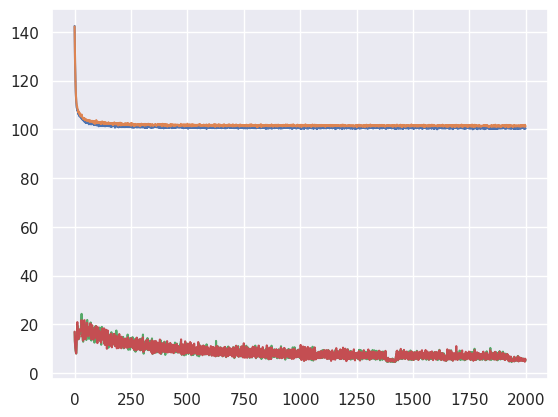

In [12]:
plt.plot(loss["R1_loss"])
plt.plot(loss["R2_loss"])
plt.plot(loss["R1X_R2X"])
plt.plot(loss["R1Y_R2Y"])
# plt.plot(loss_Y)
plt.show()

In [23]:
plt.plot(loss_X)
plt.plot(test_loss_X)

NameError: name 'loss_X' is not defined

In [29]:
class joint_expected_dev():

    def __init__(self, regressor, lie_degree_1, lie_degree_2, num_samples_2, whole_dev=True, add_time=True, device='cuda'):
        super(joint_expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor
        self.regressor_X.to(device)
        
        self.whole_dev = whole_dev
        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = num_samples_2
        self.lie_degree_2 = lie_degree_2
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2,
                                          hidden_size=self.lie_degree_2,
                                          input_dim=2 * self.lie_degree_1 ** 2,
                                          add_time=add_time,
                                          include_initial=False,
                                          return_sequence=False)
        self.pcf_level_2.to(device)



    def train_M(self, X_dl, Y_dl, X_test_dl, Y_test_dl, iterations):
        best_loss = 0.

        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.02)
        losses = {"R1X_R2Y_loss":[], "Out-of-sample-loss":[]}
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):

            X, past_dev_X = next(iter(X_dl))
            Y, past_dev_Y = next(iter(Y_dl))
            with torch.no_grad():
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X, self.device)
                    exp_dev_Y = self.regressor_X(Y, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_X(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_X = past_dev_X.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_Y = past_dev_Y.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
            
            
                if i % 5 == 0:
                    X_test, past_dev_X_test = next(iter(X_test_dl))
                    Y_test, past_dev_Y_test = next(iter(Y_test_dl))
                    
                    if self.whole_dev:
                        exp_dev_X_test = self.regressor_X(X_test, self.device)
                        exp_dev_Y_test = self.regressor_X(Y_test, self.device)
                        exp_dev_X_test = (past_dev_X_test @ exp_dev_X_test).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_Y_test = (past_dev_Y_test @ exp_dev_Y_test).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    else:
                        exp_dev_X_test = self.regressor_X(X_test, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_Y_test = self.regressor_X(Y_test, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                         exp_dev_X_test = past_dev_X_test.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                         exp_dev_Y_test = past_dev_Y_test.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        
                        
                    exp_dev_X_test = torch.cat([exp_dev_X_test.real, exp_dev_X_test.imag], -1)
                    exp_dev_Y_test = torch.cat([exp_dev_Y_test.real, exp_dev_Y_test.imag], -1)

            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            losses["R1X_R2Y_loss"].append(-char_loss.item())
            
            with torch.no_grad():
                if i % 5 == 0:
                    
                    char_loss_ = self.pcf_level_2.distance_measure(exp_dev_X_test, exp_dev_Y_test, Lambda=0)
                    losses["Out-of-sample-loss"].append(char_loss_.item())
            
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i % 100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
        
        return losses

    def evaluate(self, X_dl, Y_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X, past_dev_X = next(iter(X_dl))
                Y, past_dev_Y = next(iter(Y_dl))
                X_, past_dev_X_ = next(iter(X_dl))
                
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X, self.device)
                    exp_dev_X_ = self.regressor_X(X_, self.device)
                    exp_dev_Y = self.regressor_X(Y, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_X_ = (past_dev_X_ @ exp_dev_X_).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_X(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_X = past_dev_X.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_X_ = past_dev_X_.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_Y = past_dev_Y.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag], -1)
                
                if i == 0:
                    print(exp_dev_X.shape, exp_dev_Y.shape, exp_dev_X_.shape)

                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        self.print_hist(MMD_1, MMD_2)
        return MMD_1, MMD_2
    
    
    def permutation_test(self, X, Y, sample_size, num_permutations=500):
        with torch.no_grad():
            self.pcf_level_2.eval()
            self.regressor_X.eval()

#             X = self.subsample(X, sample_size).to(self.device)
#             Y = self.subsample(Y, sample_size).to(self.device)

            # print(t1)
#             n, m = X.shape[0], Y.shape[0]
#             combined = torch.cat([X, Y])
            H0_stats = np.zeros((num_permutations))
            H1_stats = np.zeros((num_permutations))

            for i in tqdm(range(num_permutations)):
                X_sample, past_dev_X = self.subsample(X, sample_size)
                Y_sample, past_dev_Y = self.subsample(Y, sample_size)
                
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X_sample, self.device)
                    exp_dev_Y = self.regressor_X(Y_sample, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_X(Y_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_X = past_dev_X.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_Y = past_dev_Y.reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                
#                 exp_dev_X = self.regressor_X(X_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                 exp_dev_Y = self.regressor_X(Y_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                
#                 exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                 exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
                if i == 0:
                    print(exp_dev_X.shape, exp_dev_Y.shape)
                n, m = exp_dev_X.shape[0], exp_dev_Y.shape[0]
                combined = torch.cat([exp_dev_X, exp_dev_Y])
                
                
                idx = torch.randperm(n + m)
                H0_stats[i] = self.pcf_level_2.distance_measure(combined[idx[:n]], combined[idx[n:]],  Lambda=0)
                H1_stats[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y,  Lambda=0)
            Q_a = np.quantile(np.array(H0_stats), q=0.95)
            Q_b = np.quantile(np.array(H1_stats), q=0.05)

            # print(statistics)
            # print(np.array(statistics))
            power = 1 - (Q_a > np.array(H1_stats)).sum() / num_permutations
            type1_error = (Q_b < np.array(H0_stats)).sum() / num_permutations
            
            self.print_hist(H0_stats, H1_stats)
        return power, type1_error, H0_stats, H1_stats

    def subsample(self, data, sample_size):
        idx = torch.randint(low=0, high=data.shape[0], size=[sample_size])
        return data[idx]
    
    def print_hist(self, hist_1, hist_2):
        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.hist(hist_1, bins=25, label='H_0',edgecolor='#E6E6E6')
        ax.hist(hist_2, bins=25, label='H_A',edgecolor='#E6E6E6')

        ax.legend(loc='upper right', ncol=2, fontsize=22)
        ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
        ax.set_ylabel('Count', labelpad=10)

        plt.tight_layout(pad=3.0)
        # plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
        plt.show()
        
        
class separate_expected_dev():

    def __init__(self, regressor_X, regressor_Y, lie_degree_1, lie_degree_2, num_samples_2, whole_dev=True, add_time=True, device='cuda'):
        super(separate_expected_dev, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.device = device
        self.regressor_X = regressor_X
        self.regressor_X.to(device)
        self.regressor_Y = regressor_Y
        self.regressor_Y.to(device)
        
        self.whole_dev = whole_dev
        self.lie_degree_1 = lie_degree_1
        self.add_time = add_time
        self.num_samples_2 = num_samples_2
        self.lie_degree_2 = lie_degree_2
        self.pcf_level_2 = char_func_path(num_samples=self.num_samples_2,
                                          hidden_size=self.lie_degree_2,
                                          input_dim=2 * self.lie_degree_1 ** 2,
                                          add_time=add_time,
                                          include_initial=False,
                                          return_sequence=False)
        self.pcf_level_2.to(device)



    def train_M(self, X_dl, Y_dl, X_test_dl, Y_test_dl, iterations):
        best_loss = 0.

        char_2_optimizer = torch.optim.Adam(self.pcf_level_2.parameters(), betas=(0, 0.9), lr=0.02)
        losses = {"R1X_R2Y_loss":[], "R1X_R2X_loss":[], "R1Y_R2Y_loss":[], "R1Y_R2X_loss":[], "Out-of-sample-loss":[]}
        print('start opitmize charateristics function')
        self.regressor_X.eval()
        self.regressor_Y.eval()
        self.pcf_level_2.train()
        for i in tqdm(range(iterations)):

            X, past_dev_X = next(iter(X_dl))
            Y, past_dev_Y = next(iter(Y_dl))
            with torch.no_grad():
                
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X, self.device)
                    exp_dev_Y = self.regressor_Y(Y, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_Y(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                 print(past_dev_X.shape, exp_dev_X.shape)


                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
#                 print(past_dev_X.shape, exp_dev_X.shape)
                
                if i % 5 == 0:
                
#                     exp_dev_XY = self.regressor_X(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_YX = self.regressor_Y(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
# #     #                 print(past_dev_X.shape, exp_dev_X.shape)
#                     exp_dev_XY = (past_dev_Y @ exp_dev_XY).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_YX = (past_dev_X @ exp_dev_YX).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                     exp_dev_XY = torch.cat([exp_dev_XY.real, exp_dev_XY.imag], -1)
#                     exp_dev_YX = torch.cat([exp_dev_YX.real, exp_dev_YX.imag], -1)
                    X_test, past_dev_X_test = next(iter(X_test_dl))
                    Y_test, past_dev_Y_test = next(iter(Y_test_dl))
                    
                    
                    if self.whole_dev:
                        exp_dev_X_test = self.regressor_X(X_test, self.device)
                        exp_dev_Y_test = self.regressor_Y(Y_test, self.device)
                        exp_dev_X_test = (past_dev_X_test @ exp_dev_X_test).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_Y_test = (past_dev_Y_test @ exp_dev_Y_test).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_XY = self.regressor_X(Y, self.device)
                        exp_dev_YX = self.regressor_Y(X, self.device)
                        exp_dev_XY = (past_dev_Y @ exp_dev_XY).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_YX = (past_dev_X @ exp_dev_YX).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        
                    else:
                        exp_dev_X_test = self.regressor_X(X_test, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_Y_test = self.regressor_Y(Y_test, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_XY = self.regressor_X(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        exp_dev_YX = self.regressor_Y(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                        
                    exp_dev_X_test = torch.cat([exp_dev_X_test.real, exp_dev_X_test.imag], -1)
                    exp_dev_Y_test = torch.cat([exp_dev_Y_test.real, exp_dev_Y_test.imag], -1)
                    exp_dev_XY = torch.cat([exp_dev_XY.real, exp_dev_XY.imag], -1)
                    exp_dev_YX = torch.cat([exp_dev_YX.real, exp_dev_YX.imag], -1)
                
            char_2_optimizer.zero_grad()
            char_loss = - self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
            
            
            losses["R1X_R2Y_loss"].append(-char_loss.item())
            with torch.no_grad():
                if i % 5 == 0:
                    char_loss_ = self.pcf_level_2.distance_measure(exp_dev_XY, exp_dev_Y, Lambda=0)
                    losses["R1Y_R2Y_loss"].append(char_loss_.item())
                    char_loss_ = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_YX, Lambda=0)
                    losses["R1X_R2X_loss"].append(char_loss_.item())
                    char_loss_ = self.pcf_level_2.distance_measure(exp_dev_XY, exp_dev_YX, Lambda=0)
                    losses["R1Y_R2X_loss"].append(char_loss_.item())
                    
                    char_loss_ = self.pcf_level_2.distance_measure(exp_dev_X_test, exp_dev_Y_test, Lambda=0)
                    losses["Out-of-sample-loss"].append(char_loss_.item())
                    
                
            if -char_loss > best_loss:
                print("Loss updated: {}".format(-char_loss))
                best_loss = -char_loss
            if i % 100 == 0:
                print("Iteration {} :".format(i), " loss = {}".format(-char_loss))
            char_loss.backward()
            char_2_optimizer.step()
        
        return losses

    def evaluate(self, X_dl, Y_dl):
        self.pcf_level_2.eval()
        self.regressor_X.eval()
        self.regressor_Y.eval()
        repeats = 100
        MMD_1 = np.zeros((repeats))
        MMD_2 = np.zeros((repeats))
        with torch.no_grad():
            for i in tqdm(range(repeats)):
                X, past_dev_X = next(iter(X_dl))
                Y, past_dev_Y = next(iter(Y_dl))
                X_, past_dev_X_ = next(iter(X_dl))
                
                
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X, self.device)
                    exp_dev_X_ = self.regressor_X(X_, self.device)
                    exp_dev_Y = self.regressor_Y(Y, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_X_ = (past_dev_X_ @ exp_dev_X_).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_X_ = self.regressor_X(X_, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_Y(Y, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])

                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
                exp_dev_X_ = torch.cat([exp_dev_X_.real, exp_dev_X_.imag], -1)

                MMD_1[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_X_, Lambda=0)
                MMD_2[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
        self.print_hist(MMD_1, MMD_2)
        return MMD_1, MMD_2
    
    
    def permutation_test(self, X, Y, sample_size, num_permutations=500):
        with torch.no_grad():
            self.pcf_level_2.eval()
            self.regressor_X.eval()
            self.regressor_Y.eval()
#             X = self.subsample(X, sample_size).to(self.device)
#             Y = self.subsample(Y, sample_size).to(self.device)

            # print(t1)
#             n, m = X.shape[0], Y.shape[0]
#             combined = torch.cat([X, Y])
            H0_stats = np.zeros((num_permutations))
            H1_stats = np.zeros((num_permutations))

            for i in tqdm(range(num_permutations)):
                X_sample, past_dev_X = self.subsample(X, sample_size)
                Y_sample, past_dev_Y = self.subsample(Y, sample_size)
                
                
                
                
                if self.whole_dev:
                    exp_dev_X = self.regressor_X(X_sample, self.device)
                    exp_dev_Y = self.regressor_Y(Y_sample, self.device)
                    exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                else:
                    exp_dev_X = self.regressor_X(X_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                    exp_dev_Y = self.regressor_Y(Y_sample, self.device).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
                
                exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
                exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
                
                n, m = exp_dev_X.shape[0], exp_dev_Y.shape[0]
                combined = torch.cat([exp_dev_X, exp_dev_Y])
                
                
                idx = torch.randperm(n + m)
                H0_stats[i] = self.pcf_level_2.distance_measure(combined[idx[:n]], combined[idx[n:]],  Lambda=0)
                H1_stats[i] = self.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y,  Lambda=0)
            Q_a = np.quantile(np.array(H0_stats), q=0.95)
            Q_b = np.quantile(np.array(H1_stats), q=0.05)

            # print(statistics)
            # print(np.array(statistics))
            power = 1 - (Q_a > np.array(H1_stats)).sum() / num_permutations
            type1_error = (Q_b < np.array(H0_stats)).sum() / num_permutations
            
            self.print_hist(H0_stats, H1_stats)
        return power, type1_error, H0_stats, H1_stats

    def subsample(self, data, sample_size):
        idx = torch.randint(low=0, high=data.shape[0], size=[sample_size])
        return data[idx]
    

    
    def print_hist(self, hist_1, hist_2):
        fig, ax = plt.subplots(1,1,figsize=(15,5))

        ax.hist(hist_1, bins=25, label='H_0',edgecolor='#E6E6E6')
        ax.hist(hist_2, bins=25, label='H_A',edgecolor='#E6E6E6')

        ax.legend(loc='upper right', ncol=2, fontsize=22)
        ax.set_xlabel('D_1(X, Y)^2', labelpad=10)
        ax.set_ylabel('Count', labelpad=10)

        plt.tight_layout(pad=3.0)
        # plt.savefig('MMD_binary_tex.pdf',bbox_inches='tight')
        plt.show()

In [30]:
# expected_devx = joint_expected_dev(regressor = trained_regressor_X, 
#                              lie_degree_1 = 5, lie_degree_2 = 8, num_samples_2 = 10, whole_dev=False)

expected_devx = separate_expected_dev(regressor_X = trained_regressor_X, regressor_Y = trained_regressor_Y, 
                             lie_degree_1 = 5, lie_degree_2 = 8, num_samples_2 = 10, whole_dev=True)

In [31]:
losses = expected_devx.train_M(train_pcf_X_dl, train_pcf_Y_dl, test_pcf_X_dl, test_pcf_Y_dl, 500)

start opitmize charateristics function


  0%|          | 0/500 [00:00<?, ?it/s]

Loss updated: 0.015000852756202221
Iteration 0 :  loss = 0.015000852756202221
Loss updated: 0.015921050682663918
Loss updated: 0.01601136289536953
Loss updated: 0.016783038154244423
Loss updated: 0.017614198848605156
Loss updated: 0.017931973561644554
Loss updated: 0.018334614112973213
Loss updated: 0.019860876724123955
Loss updated: 0.020022770389914513
Loss updated: 0.02055935561656952
Loss updated: 0.02132112719118595
Loss updated: 0.022247014567255974
Loss updated: 0.023006688803434372
Loss updated: 0.023021293804049492
Loss updated: 0.023834599182009697
Loss updated: 0.023855198174715042
Loss updated: 0.02459404058754444
Loss updated: 0.025069210678339005
Loss updated: 0.025569308549165726
Loss updated: 0.025641804561018944
Loss updated: 0.026579100638628006
Loss updated: 0.02712092362344265
Loss updated: 0.027559924870729446
Loss updated: 0.029264647513628006
Loss updated: 0.0294162817299366
Loss updated: 0.02955196611583233
Loss updated: 0.03079257346689701
Loss updated: 0.03089

In [31]:
losses.keys()

dict_keys(['R1X_R2Y_loss', 'R1X_R2X_loss', 'R1Y_R2Y_loss', 'R1Y_R2X_loss', 'Out-of-sample-loss'])

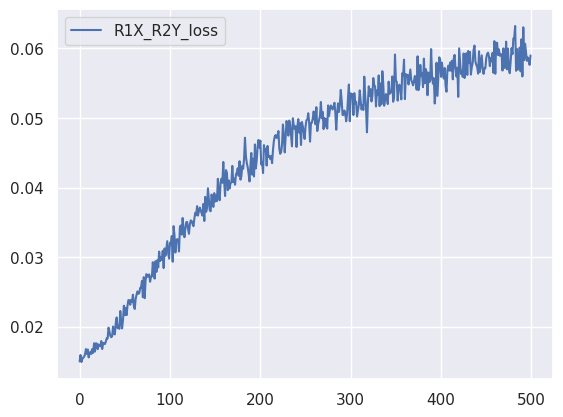

In [32]:
plt.plot(losses['R1X_R2Y_loss'], label = "R1X_R2Y_loss")
plt.legend()
plt.show()

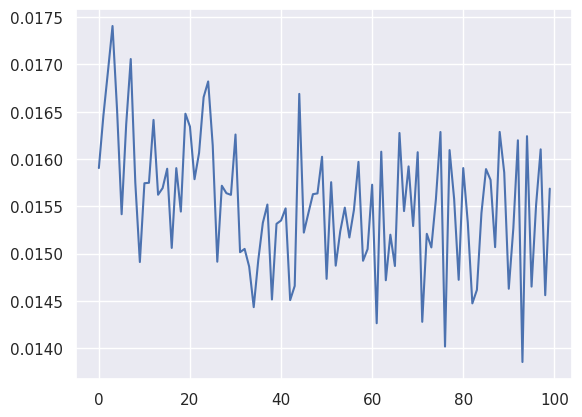

In [33]:
plt.plot(losses['Out-of-sample-loss'], label = "Out-of-sample-loss")

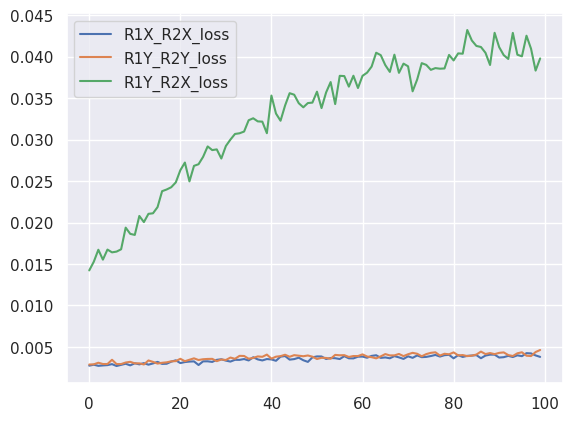

In [34]:
plt.plot(losses['R1X_R2X_loss'], label = "R1X_R2X_loss")
plt.plot(losses['R1Y_R2Y_loss'], label = "R1Y_R2Y_loss")
plt.plot(losses['R1Y_R2X_loss'], label = "R1Y_R2X_loss")
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

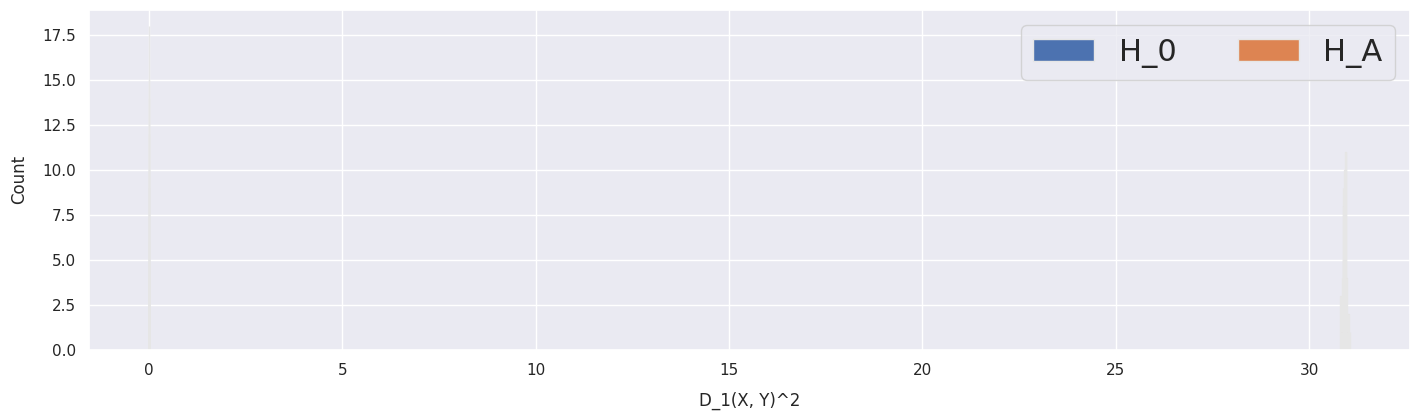

In [38]:
MMD_1, MMD_2 = expected_devx.evaluate(test_pcf_X_dl, test_pcf_Y_dl)

  0%|          | 0/500 [00:00<?, ?it/s]

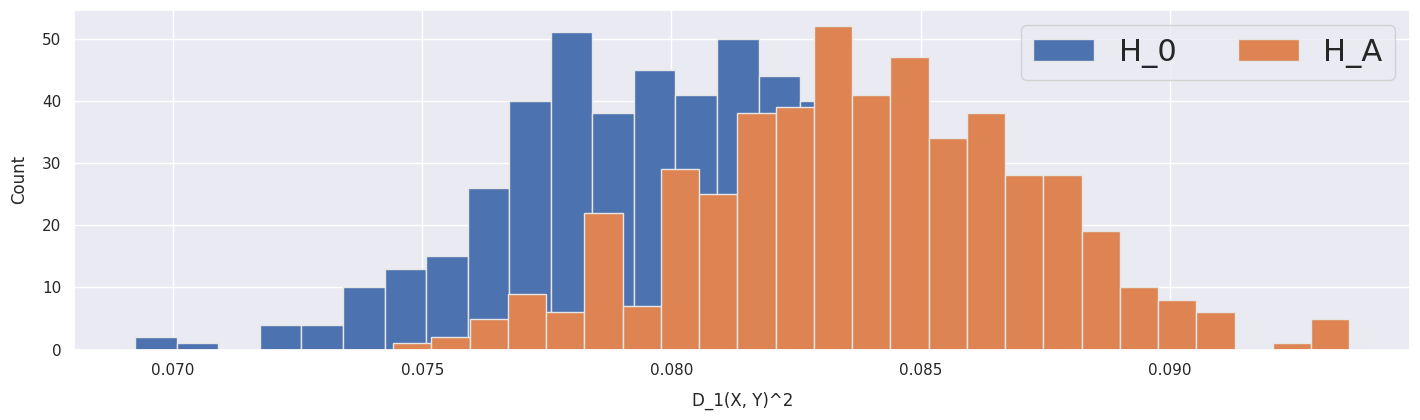

In [24]:
power, type1_error, H0_stats, H1_stats = expected_devx.permutation_test(test_pcf_X_ds, 
                                                                        test_pcf_Y_ds, 
                                                                        sample_size = 200, 
                                                                        num_permutations=500)

  0%|          | 0/500 [00:00<?, ?it/s]

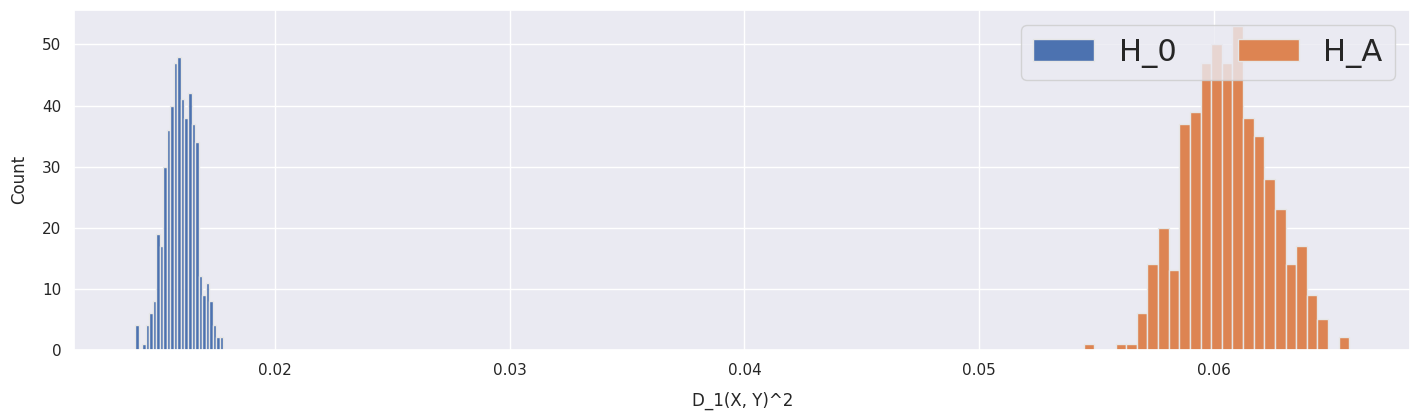

In [28]:
power, type1_error, H0_stats, H1_stats = expected_devx.permutation_test(train_pcf_X_ds, 
                                                                        train_pcf_Y_ds, 
                                                                        sample_size = 1000, 
                                                                        num_permutations=500)

In [25]:
power

0.30600000000000005

In [26]:
type1_error

0.68

In [60]:
x_sample, x_dev_sample = next(iter(train_X_dl))
reg_x = trained_regressor_X(x_sample, device)
y_sample, y_dev_sample = next(iter(train_Y_dl))
reg_y = trained_regressor_X(y_sample, device)

In [62]:
torch.norm(reg_x - x_dev_sample, dim = (2,3)).mean(0).sum()

tensor(83.3753, device='cuda:0', grad_fn=<SumBackward0>)

In [28]:
torch.norm(reg_y - y_dev_sample, dim = (2,3)).mean(0)

tensor([2.2251, 2.2240, 2.2246, 2.2264, 2.2249, 2.2270, 2.2258, 2.2285, 2.2298,
        2.2374, 2.2417, 2.2456, 2.2508, 2.2591, 2.2611, 2.2762, 2.2870, 2.2953,
        2.3108, 2.3209, 2.3329, 2.3583, 2.3833, 2.4049, 2.4154, 2.4296, 2.4434,
        2.4458, 2.4757, 2.5023, 2.5244, 2.5358, 2.5295, 2.5421, 2.5469, 2.5223,
        2.5005, 2.5001, 2.4568, 2.4361, 2.3878, 2.3240, 2.2215, 2.1581, 2.0547,
        1.9532, 1.8326, 1.5916, 1.2503, 0.8637, 0.1235], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [64]:
torch.norm(reg_x - reg_y, dim = (2,3)).mean(0).sum()

tensor(59.2037, device='cuda:0', grad_fn=<SumBackward0>)

In [65]:
torch.norm(x_dev_sample - y_dev_sample, dim = (2,3)).mean(0)

tensor(142.5012, device='cuda:0')

In [37]:
torch.norm(torch.randn(reg_x.shape).to(device) - x_dev_sample, dim = (2,3)).mean(0)

tensor([5.4815, 5.4462, 5.3074, 5.4947, 5.4738, 5.4497, 5.3522, 5.4273, 5.4093,
        5.4442, 5.4787, 5.4453, 5.3965, 5.4555, 5.4951, 5.4830, 5.4290, 5.4030,
        5.3966, 5.3508, 5.4065, 5.3942, 5.4105, 5.5259, 5.3358, 5.4166, 5.5029,
        5.4579, 5.4390, 5.4237, 5.4852, 5.4263, 5.5251, 5.5145, 5.3986, 5.4524,
        5.3762, 5.4760, 5.5242, 5.4604, 5.4021, 5.4774, 5.4267, 5.3371, 5.3383,
        5.5128, 5.4279, 5.3168, 5.3398, 5.4773, 5.3404], device='cuda:0')

tensor([2.2210, 2.2186, 2.2183, 2.2168, 2.2162, 2.2105, 2.2050, 2.2049, 2.2008,
        2.1940, 2.1882, 2.1786, 2.1643, 2.1497, 2.1213, 2.1042, 2.0695, 2.0405,
        2.0132, 1.9862, 1.9482, 1.9172, 1.8840, 1.8478, 1.7980, 1.7489, 1.7008,
        1.6550, 1.6167, 1.5667, 1.5033, 1.4661, 1.3977, 1.3396, 1.2705, 1.2030,
        1.1722, 1.1396, 1.0966, 1.0443, 1.0002, 0.9457, 0.8936, 0.8640, 0.7797,
        0.7269, 0.6745, 0.6312, 0.5906, 0.5701, 0.1274], device='cuda:0',
       grad_fn=<MeanBackward1>)

tensor([0.0724, 0.0866, 0.1077, 0.1401, 0.1776, 0.2153, 0.2505, 0.2893, 0.3362,
        0.3902, 0.4543, 0.5252, 0.6011, 0.6787, 0.7608, 0.8356, 0.9152, 0.9909,
        1.0591, 1.1371, 1.2164, 1.3146, 1.4073, 1.4782, 1.5381, 1.6160, 1.7007,
        1.7916, 1.8846, 1.9611, 2.0208, 2.0790, 2.1318, 2.1750, 2.2005, 2.1877,
        2.1835, 2.2005, 2.2053, 2.2064, 2.2192, 2.1530, 2.0854, 2.0338, 1.9748,
        1.8618, 1.6905, 1.4729, 1.1624, 0.6561, 0.2147], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [34]:
torch.norm(x_dev_sample - y_dev_sample, dim = (2,3)).mean(0)

tensor([3.0887, 3.1001, 3.1218, 3.1256, 3.1175, 3.1294, 3.1298, 3.1365, 3.0983,
        3.1098, 3.1024, 3.0848, 3.0707, 3.0737, 3.0735, 3.0572, 3.0593, 3.0498,
        3.0638, 3.0553, 3.0301, 3.0439, 3.0318, 3.0067, 2.9933, 3.0237, 3.0177,
        3.0147, 3.0122, 3.0037, 2.9896, 2.9584, 2.9711, 2.9748, 2.9504, 2.8849,
        2.8382, 2.7938, 2.7391, 2.7084, 2.6749, 2.5552, 2.4381, 2.3191, 2.2938,
        2.1451, 1.9921, 1.7927, 1.5860, 1.2007, 0.0000], device='cuda:0')

  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50]) torch.Size([2048, 51, 50])
torch.Size([1024, 51, 50]) t

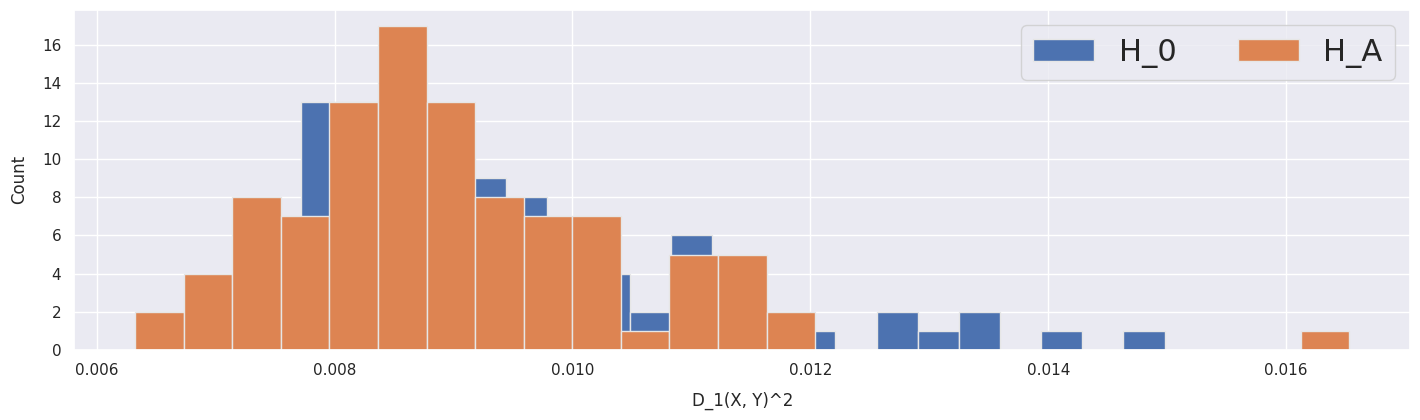

In [32]:
num_permutations = 100
with torch.no_grad():
    expected_devx.pcf_level_2.eval()
    expected_devx.regressor_X.eval()

#             X = self.subsample(X, sample_size).to(self.device)
#             Y = self.subsample(Y, sample_size).to(self.device)

    # print(t1)
#     n, m = X.shape[0], Y.shape[0]
#     combined = torch.cat([X, Y])
    H0_stats = np.zeros((num_permutations))
    H1_stats = np.zeros((num_permutations))

    for i in tqdm(range(num_permutations)):
        X_sample = next(iter(test_path_X_dl)).to(expected_devx.device)
        Y_sample = next(iter(test_path_Y_dl)).to(expected_devx.device)

        exp_dev_X = expected_devx.regressor_X(X_sample, expected_devx.device).reshape([-1, X_sample.shape[1], expected_devx.lie_degree_1 ** 2])
        exp_dev_Y = expected_devx.regressor_X(Y_sample, expected_devx.device).reshape([-1, Y_sample.shape[1], expected_devx.lie_degree_1 ** 2])

        exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
        exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)

        n, m = exp_dev_X.shape[0], exp_dev_Y.shape[0]
        combined = torch.cat([exp_dev_X, exp_dev_Y])

        print(exp_dev_X.shape, exp_dev_Y.shape, combined.shape)
        idx = torch.randperm(n + m)
        H0_stats[i] = expected_devx.pcf_level_2.distance_measure(combined[idx[:n]], combined[idx[n:]],  Lambda=0)
        H1_stats[i] = expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y,  Lambda=0)
    Q_a = np.quantile(np.array(H0_stats), q=0.95)
    Q_b = np.quantile(np.array(H1_stats), q=0.05)

    # print(statistics)
    # print(np.array(statistics))
    power = 1 - (Q_a > np.array(H1_stats)).sum() / num_permutations
    type1_error = (Q_b < np.array(H0_stats)).sum() / num_permutations

    expected_devx.print_hist(H0_stats, H1_stats)

In [45]:
x_dev_sample.shape

torch.Size([1024, 51, 5, 5])

In [13]:
regressor_for_X.M

AttributeError: 'LSTMRegressor' object has no attribute 'M'

In [47]:
expected_devx.pcf_level_2.eval()


X, past_dev_X = next(iter(train_pcf_X_dl))
# X, past_dev_X = test_pcf_X_ds[:200]
Y, past_dev_Y = next(iter(train_pcf_Y_dl))
# Y, past_dev_Y = test_pcf_Y_ds[:200]
with torch.no_grad():
    exp_dev_X = expected_devx.regressor_X(X, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1 ** 2])
    exp_dev_Y = expected_devx.regressor_X(Y, expected_devx.device).reshape([-1, X.shape[1], expected_devx.lie_degree_1 ** 2])
#                 print(past_dev_X.shape, exp_dev_X.shape)
#                 exp_dev_X = (past_dev_X @ exp_dev_X).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])
#                 exp_dev_Y = (past_dev_Y @ exp_dev_Y).reshape([-1, X.shape[1], self.lie_degree_1 ** 2])

    exp_dev_X = torch.cat([exp_dev_X.real, exp_dev_X.imag], -1)
    exp_dev_Y = torch.cat([exp_dev_Y.real, exp_dev_Y.imag], -1)
    print(exp_dev_X.shape, exp_dev_Y.shape)

    char_loss = - expected_devx.pcf_level_2.distance_measure(exp_dev_X, exp_dev_Y, Lambda=0)
    print(char_loss)

torch.Size([1024, 51, 50]) torch.Size([1024, 51, 50])
tensor(-0.0700, device='cuda:0')
